# HOMEWORK 2

In [35]:
import pandas as pd
import numpy as np
import datetime
import warnings
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [36]:
filepath_tsdata = f'/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/treasury_ts_2015-08-15 (1).xlsx'
info = pd.read_excel(filepath_tsdata,sheet_name='info',index_col=0)
tsdata = pd.read_excel(filepath_tsdata,sheet_name='database')
tsdata.columns = tsdata.columns.str.upper()


tsdata_2 = pd.read_excel(filepath_tsdata,sheet_name='info',index_col= 0).T
tsdata_2.columns = tsdata_2.columns.str.upper()
tsdata_2.set_index('KYTREASNO',inplace=True)

In [37]:
rawdata = tsdata[tsdata['CALDT'] == '2008-11-04']
rawdata.set_index('KYTREASNO',inplace = True)
rawdata

,KYCRSPID,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,TDDURATN,TDPUBOUT,TDTOTOUT,TDPDINT,TDIDXRATIO,TDIDXRATIO_FLG
KYTREASNO,,,,,,,,,,,,,,,,
204047,2.015082e+07,2008-11-04,105.953125,105.984375,105.96875,M,X,0.935462,0.011642,0.000089,2168.016569,20998.0,32470.0,0.0,NaN,NaN
204046,2.015082e+07,2008-11-04,141.859375,141.890625,141.87500,M,X,2.338655,0.009720,0.000098,1910.307862,2852.0,4024.0,0.0,NaN,NaN


1.1)

In [38]:
t_current = dt.datetime.strptime('2008-11-04',"%Y-%m-%d")
t_maturity = dt.datetime.strptime('2015-08-15',"%Y-%m-%d")

metrics = rawdata.copy()[['TDYLD','TDDURATN','TDASK','TDBID','TDACCINT']]
metrics.columns = ['ytm','duration','ASK','BID','accrued_interest']
metrics.insert(value=tsdata_2.loc[[204047,204046],'TCOUPRT'].values,loc=0,column='coupon rate')
metrics['ytm'] *= 365.25
metrics['duration'] /= 365.25
metrics['modified_duration'] = 1/(1+metrics['ytm']/2)*metrics['duration']
metrics['dirty_price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['maturity_interval'] = get_maturity_delta(t_maturity,t_current)

In [39]:
metrics

,coupon rate,ytm,duration,ASK,BID,accrued_interest,modified_duration,dirty_price,maturity_interval
KYTREASNO,,,,,,,,,
204047,4.25,0.032362,5.935706,105.984375,105.953125,0.935462,5.841189,106.904212,6.776181
204046,10.625,0.035753,5.230138,141.890625,141.859375,2.338655,5.138284,144.213655,6.776181


1.2)

In [40]:
metrics['clean_price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 
metrics['dollar_duration'] = metrics['clean_price'] * metrics['duration']
n_i = 50 * 1e6 / metrics['clean_price'].loc[204046]
n_j = - n_i * metrics['dollar_duration'].loc[204046]/ metrics['dollar_duration'].loc[204047]
print(f'The number of notes position to hedge duration is {n_j}.')
print(f"The total dollars in the short position is {n_j * metrics['clean_price'].loc[204047]}.")

The number of notes position to hedge duration is -415750.6711185452.
The total dollars in the short position is -44056578.93009333.


In [41]:
delta_price = (metrics[['modified_duration']].loc[204046] * 0.00005 * n_i).to_frame('short_pos')
delta_price['long_pos'] = metrics[['modified_duration']].loc[204047] * - 0.00005 * n_j
delta_price['net_total'] = delta_price['long_pos'] + delta_price['short_pos'] 
display(delta_price)
delta_price_converg = (metrics['ytm'].loc[204046] - metrics['ytm'].loc[204047] ) / 0.0001 * delta_price 
display(delta_price_converg)

,short_pos,long_pos,net_total
modified_duration,90.542453,121.423904,211.966357


,short_pos,long_pos,net_total
modified_duration,3069.671072,4116.648391,7186.319463


1.4)

In [42]:
tmp_data = tsdata[tsdata['CALDT'] == '2008-11-25']
tmp_data.set_index('KYTREASNO',inplace = True)

metrics['dirty_price_2008_11_25'] = ((tmp_data['TDBID'] + tmp_data['TDASK'])/2 + tmp_data['TDACCINT']).tolist()
metrics['ytm_2008_11_25'] = tmp_data['TDYLD'] * 365
metrics['pnl_2008_11_25'] = (metrics['dirty_price_2008_11_25']- metrics['dirty_price']) * np.array([n_i,n_j])

tmp_data = tsdata[tsdata['CALDT'] == '2008-12-16']
tmp_data.set_index('KYTREASNO',inplace = True)

metrics['dirty_price_2008_12_16'] = ((tmp_data['TDBID'] + tmp_data['TDASK'])/2 + tmp_data['TDACCINT']).tolist()
metrics['ytm_2008_12_16'] = tmp_data['TDYLD'] * 365
metrics['pnl_2008_12_16'] = (metrics['dirty_price_2008_12_16']- metrics['dirty_price']) * np.array([n_i,n_j])

metrics

,coupon rate,ytm,duration,ASK,BID,accrued_interest,modified_duration,dirty_price,maturity_interval,clean_price,dollar_duration,dirty_price_2008_11_25,ytm_2008_11_25,pnl_2008_11_25,dirty_price_2008_12_16,ytm_2008_12_16,pnl_2008_12_16
KYTREASNO,,,,,,,,,,,,,,,,,
204047,4.25,0.032362,5.935706,105.984375,105.953125,0.935462,5.841189,106.904212,6.776181,105.96875,628.999331,111.990489,0.024770,1.792521e+06,118.936141,0.014750,4.240328e+06
204046,10.625,0.035753,5.230138,141.890625,141.859375,2.338655,5.138284,144.213655,6.776181,141.87500,742.025812,148.819973,0.030066,-1.915080e+06,155.488791,0.021912,-4.687645e+06


2.1)

In [43]:

QUOTE_DATE = '2022-09-30'

filepath_rawdata = f'/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/treasury_quotes_2022-09-30 (2).xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','TDYLD','duration','outstanding']
metrics['TDYLD'] *= 365.25
metrics['duration'] /= 365.25
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)

In [44]:
metrics

,issue date,maturity date,coupon rate,TDYLD,duration,outstanding,maturity,price,ask-bid,next cashflow date
KYTREASNO,,,,,,,,,,
207892,2022-06-07,2022-10-04,0.000,0.024303,0.010951,NaN,0.010951,99.973389,0.000111,2022-10-04
207774,2021-10-07,2022-10-06,0.000,0.023746,0.016427,NaN,0.016427,99.961000,0.000167,2022-10-06
207893,2022-06-14,2022-10-11,0.000,0.024867,0.030116,NaN,0.030116,99.925139,0.000306,2022-10-11
207868,2022-04-14,2022-10-13,0.000,0.025935,0.035592,NaN,0.035592,99.907736,0.000361,2022-10-13
207430,2019-10-15,2022-10-15,1.375,0.028760,0.041068,2.323500e+10,0.041068,100.568648,0.031250,2022-10-15
...,...,...,...,...,...,...,...,...,...,...
207808,2021-11-15,2051-11-15,1.875,0.037882,20.492196,6.897200e+10,29.125257,66.640625,0.046875,2022-11-15
207849,2022-02-15,2052-02-15,2.250,0.037826,19.969176,6.300400e+10,29.377139,72.718750,0.062500,2023-02-15
207850,2022-02-15,2052-02-15,0.125,NaN,NaN,1.663300e+10,29.377139,62.910156,0.257812,2023-02-15


In [45]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
CF

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


2.2)

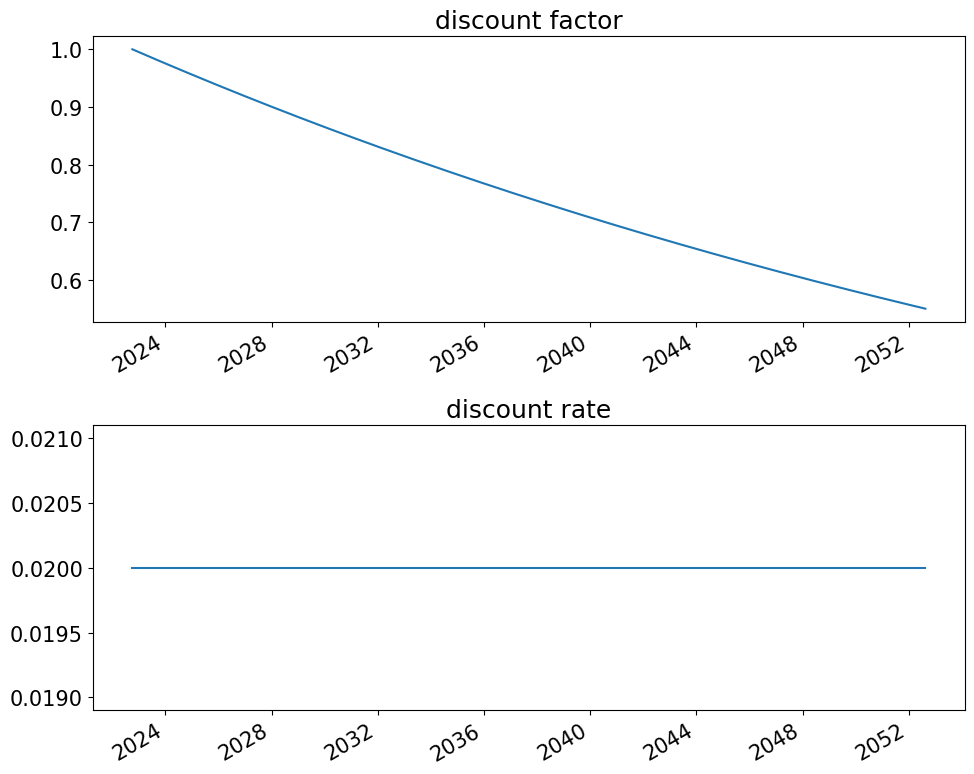

In [46]:
RATE = .02
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)
discount_factors = np.exp(-RATE * maturity_grid)

curves = pd.DataFrame(discount_factors,index=CF.columns, columns=['discount factor'])
curves['discount rate'] = RATE

fig,ax = plt.subplots(2,1,figsize=(10,8))
curves['discount factor'].plot(ax=ax[0],title='discount factor');
curves['discount rate'].plot(ax=ax[1],title = 'discount rate');
plt.tight_layout()

2.3)

In [47]:
def discounted_price(CF,t_current, convert_to_discount=True, price_coupons=False):

    maturity = get_maturity_delta(CF.columns, t_current)

    disc = np.zeros(maturity.shape)
    for i, mat in enumerate(maturity):
        disc[i] = np.e ** (-RATE * mat) 

    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price

CF_prices = discounted_price(CF,t_current,price_coupons=True)
model_prices = CF_prices.sum(axis=1)

CF_wts = CF_prices.div(model_prices,axis=0)
display(CF_wts.iloc[-5:,-10:].style.format('{:.2%}'))

CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current)
model_duration = (CF_wts * CF_intervals).sum(axis=1)

,2050-05-15 00:00:00,2050-08-15 00:00:00,2050-11-15 00:00:00,2051-02-15 00:00:00,2051-05-15 00:00:00,2051-08-15 00:00:00,2051-11-15 00:00:00,2052-02-15 00:00:00,2052-05-15 00:00:00,2052-08-15 00:00:00
KYTREASNO,,,,,,,,,,
207763,0.00%,0.57%,0.00%,0.57%,0.00%,56.68%,0.00%,0.00%,0.00%,0.00%
207808,0.55%,0.00%,0.55%,0.00%,0.54%,0.00%,57.68%,0.00%,0.00%,0.00%
207849,0.00%,0.61%,0.00%,0.60%,0.00%,0.60%,0.00%,53.22%,0.00%,0.00%
207891,0.69%,0.00%,0.68%,0.00%,0.67%,0.00%,0.67%,0.00%,46.62%,0.00%
207934,0.00%,0.70%,0.00%,0.69%,0.00%,0.69%,0.00%,0.68%,0.00%,45.58%


In [48]:
model_duration.describe()

count    378.000000
mean       5.150741
std        6.013043
min        0.010951
25%        0.882362
50%        2.751561
75%        5.991011
max       22.833432
dtype: float64

2.5)

In [49]:
(metrics['duration']- model_duration).describe()

count    378.000000
mean      -0.212790
std        0.469856
min       -1.958441
25%       -0.034362
50%       -0.002948
75%       -0.000018
max        0.000037
dtype: float64

2.5)

In [50]:
model_convexity = (CF_wts * (CF_intervals**2)).sum(axis=1)
model_convexity.describe()

count    378.000000
mean      72.779185
std      141.027932
min        0.000120
25%        0.779784
50%        7.734027
75%       37.571508
max      590.994649
dtype: float64

3.1)

In [51]:
filepath_tsdata = f'/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/treasury_ts_issue_duration_(207392, 207391, 207457) (1).xlsx'
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')

tsdata.columns = tsdata.columns.str.upper()

px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()

In [52]:
duration /= 365.25
duration

KYTREASNO,207391,207392,207457
CALDT,,,
2019-12-10,8.941965,21.638500,2.954547
2019-12-11,8.941365,21.675273,2.951852
2019-12-12,8.934326,21.586556,2.949051
2019-12-13,8.934586,21.645111,2.946373
2019-12-16,8.924444,21.600777,2.938128
...,...,...,...
2022-05-24,6.798743,19.704314,0.557223
2022-05-25,6.796306,19.708696,0.554485
2022-05-26,6.793620,19.677543,0.551749


In [53]:
price = px.iloc[-1]
dollar_duration = duration.iloc[-1] * price
n_i = 10000 / price[207391]
n_j = - n_i * dollar_duration[207391]/ dollar_duration[207392]
print(f"The number of short position to hedge duration is {n_j * price[207392]}.")

The number of short position to hedge duration is -3457.617006252091.


3.2)

In [54]:
trading = duration.copy() * px # using dollar duration
trading['hedge_ratio'] = trading[207391]/trading[207392] * px[207392] / px[207391]
trading['207391_POS'] = 10000
trading['207392_POS'] = -1 * trading['207391_POS'] * trading['hedge_ratio']
PnL = trading['207391_POS'].shift(1)  * px[207391].pct_change() + trading['207392_POS'].shift(1)  * px[207392].pct_change() 
PnL

CALDT
2019-12-10          NaN
2019-12-11     9.947139
2019-12-12   -14.744083
2019-12-13     8.680857
2019-12-16    -8.470957
                ...    
2022-05-24    22.188982
2022-05-25     4.948898
2022-05-26    21.522255
2022-05-27   -15.950463
2022-05-31   -13.183499
Length: 621, dtype: float64

The total profit (or loss) is -240.90969692598722.
count    620.000000
mean      -0.388564
std       18.797647
min      -98.317955
25%       -9.776653
50%       -0.077860
75%        9.250157
max      107.636148
dtype: float64


<AxesSubplot: xlabel='CALDT'>

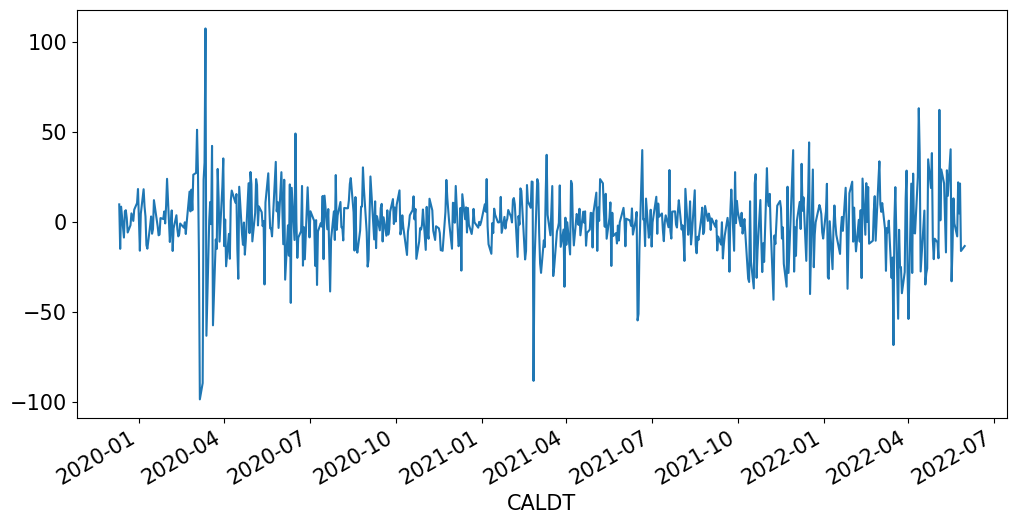

In [55]:
print('The total profit (or loss) is ',PnL.sum(),'.',sep='')
print(PnL.describe())
PnL.plot()

3.3)